In [1]:
import pandas as pd
import numpy as np
import sys
# sys.path.append('../../source')
import matplotlib.pylab as plt
# %matplotlib inline

from BetaUtils import beta_hedging_ret, get_beta
from energy_functions import correlation, neg_returns, volatility
from Hedge import Hedge


In [51]:
def generate_results_as_ts(market, portfolio, start_test_date, end_test_date, stocks_dir='../../data/all_stocks.csv',\
                           spy_dir='../../data/spy.csv', period_len=20, ols_window=60):
    """
    Generates results of beta-hedging, given a portfolio, a hedging market, a time period, and a number of desired
        periods.  
        
    Inputs:
    -------
    market: list of assets in the market that will be hedged against
    portfolio: list of assets in the portfolio that is being tested
    start_test_date: date that the testing period begins.  Given in 'yyyy-mm-dd' format.
    end_test_date: date that the testing period ends.  Given in 'yyyy-mm-dd' format.
    stocks_dir: path to a file containing the stock universe
    spy_dir: path to a file containing the results of the SPY ETF
    period_len: length in days of each time period for the time series
    ols_window: length in days of the window that is used to calculate beta using OLS
    
    Outputs:
    --------
    results: Pandas DataFrame of time series results with the following columns:
    market_correlation
    spy_correlation
    unhedged_correlation
    market_volatility
    spy_volatility
    unhedged_volatility
    market_neg_returns
    spy_neg_returns
    unhedged_neg_returns
    """
        
    hedge = Hedge(stocksdir=stocks_dir, spydir=spy_dir, begindate=start_test_date, enddate=end_test_date)
    hedge.market = market
    hedge.portfolio = portfolio
    spy = hedge.spy.pct_change()
    
    dates = hedge.allstockdf.index[window:]
    num_periods = len(dates[::period_len])
    
    # Create the columns for the df
    columns = []
    for mark in ['market','spy','unhedged']:
        for metric in ['correlation','volatility','neg_returns']:
            columns.append(mark+'_'+metric)
         
    results = pd.DataFrame(np.zeros((num_periods,9)),index=dates[::period_len], columns = columns)
    
    # Get returns hedged against market
    _, betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.dollar_market_sum_ret)
    market_hedged_returns = beta_hedging_ret(betas[1:],hedge.dollar_portfolio_sum_ret[window+1:],\
                                            hedge.dollar_market_sum_ret[window+1:])

    # Get returns hedged against S&P 500
    _, betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.spy.pct_change())
    spy_hedged_returns = beta_hedging_ret(betas[1:],hedge.dollar_portfolio_sum_ret[window+1:],\
                                            hedge.spy.pct_change()[window+1:])

    # Get unhedged returns
    unhedged_returns = hedge.dollar_portfolio_sum_ret[window+1:].values
      
    for ii,date in enumerate(dates[::period_len]):
        i_start = ii*period_len
        i_end = (ii+1)*period_len
        for metric in ['correlation','volatility','neg_returns']:
            results.loc[date,'market_' + metric]   = globals()[metric]\
                (market_hedged_returns[i_start:i_end],spy[window+1+i_start:window+1+i_end])
            results.loc[date,'spy_' + metric]      = globals()[metric]\
                (spy_hedged_returns[i_start:i_end],spy[window+1+i_start:window+1+i_end])
            results.loc[date,'unhedged_' + metric] = globals()[metric]\
                (unhedged_returns[i_start:i_end],spy[window+1+i_start:window+1+i_end])
    
#     results.sortindex()
    return results.sort_index()

In [53]:
a=generate_results_as_ts(hedge1.market, hedge1.portfolio, '2009-10-01','2010-12-31')

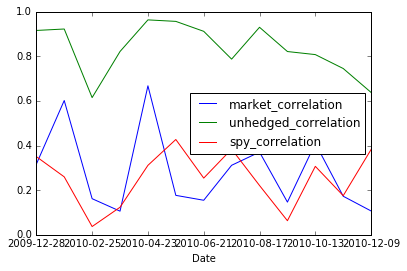

In [58]:
a[['market_correlation', 'unhedged_correlation', 'spy_correlation']].plot()